In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import sys

from pathlib import Path
import pandas as pd
from IPython.display import display
from functional import seq
import librosa
import seaborn as sns

sys.path.append("..")
from sgs_utils.path_conf import speech_data_root_dir, loc_data_dir

speech_data_session_dir = speech_data_root_dir.joinpath("backup")
display(speech_data_session_dir)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.plotting.backend = "plotly"


PosixPath('/media/speech_webapp_merged/backup')

## Downloading all the data

In [3]:
# !wget --output-document="speech_data_webapp.zip" https://cloud.ilabt.imec.be/index.php/s/tB2enWmZCJskGmG/download
# !unzip speech_data_webapp.zip
# !mv speech_web_app /project_scratch/data/
# !rm speech_data_webapp.zip


In [4]:
# so we have all folders in backup?
!ls -lh {speech_data_session_dir} | head -n 10

total 0
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:19 2020-11-25__11:08:00+01:00__59b7f538-755a-4bee-8165-158c6795b287
drwxr-xr-x 6 jonas jonas 83 Jun 27 07:19 2020-11-25__11:11:00+01:00__6fb54909-8b1d-4ff5-bc58-912249de7d94
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:19 2020-11-25__11:13:00+01:00__12cd1ed1-17ae-4a4c-8fa8-1363030736e7
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:19 2020-11-25__11:33:00+01:00__9247ce5d-23af-4af4-bb07-6c9b53f8bb90
drwxr-xr-x 4 jonas jonas 54 Jun 27 07:19 2020-11-25__11:35:00+01:00__8c449866-0ac4-4b62-a4a7-d3ce0e7781b6
drwxr-xr-x 3 jonas jonas 39 Jun 27 07:19 2020-11-25__11:45:00+01:00__a03a23eb-ca38-430d-afc6-e47dc4d71f61
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:19 2020-11-25__11:53:00+01:00__8071ebfc-e589-4175-900b-0fadf2627aa5
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:19 2020-11-25__11:54:00+01:00__f752870e-8461-4b7f-bdcc-93649b8caeaa
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:19 2020-11-25__12:15:00+01:00__2f87494b-5d33-46b3-8595-a4da6510ab1f
ls: write error: Broken pipe


In [5]:
# This snippet summarizes the dir-names of the various folders
# within `speech_data_session_dir`
dir_list = []
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue
    dir_list.extend(
        seq(folder.iterdir())
        .filter(lambda x: x.is_dir())
        .map(lambda x: x.name)
        .to_list()
    )
print(pd.Series(dir_list).value_counts())
del dir_list, folder


marloes    114
PiSCES     104
Radboud     98
demo         5
dtype: int64


## 1. Creating the metadata file

The metadata file is constructed of the `.json` file which resides within each user ID 
folder and withholds the person's metadata such as gender, age, education, used mic. etc ...

In [6]:
metadata_dict_list = []

# creating alldata.csv
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue

    metadata = folder.joinpath("metadata.json")
    if not metadata.is_file():
        continue

    with open(metadata, "r") as f:
        metadata_dict = json.load(f)
    metadata_dict["ID"] = folder.name.split("__")[-1]

    metadata_dict["Marloes"] = len(list(folder.joinpath("marloes").glob("*.wav")))
    metadata_dict["PiSCES"] = len(list(folder.joinpath("PiSCES").glob("*.wav")))
    metadata_dict["Radboud"] = len(list(folder.joinpath("Radboud").glob("*.wav")))

    metadata_dict_list.append(metadata_dict)

df_metadata = pd.DataFrame(metadata_dict_list)

# conver the columns to the correct data format
df_metadata["age"] = df_metadata["age"].astype(int)
df_metadata[["sex", "device", "education"]] = df_metadata[
    ["sex", "device", "education"]
].astype("category")
df_metadata["timestamp"] = pd.to_datetime(
    df_metadata.timestamp, utc=True
).dt.tz_convert("Europe/Brussels")

del folder, metadata_dict, metadata_dict_list, f, metadata
df_metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype                          
---  ------          --------------  -----                          
 0   age             214 non-null    int64                          
 1   education       214 non-null    category                       
 2   sex             214 non-null    category                       
 3   timestamp       214 non-null    datetime64[ns, Europe/Brussels]
 4   ID              214 non-null    object                         
 5   Marloes         214 non-null    int64                          
 6   PiSCES          214 non-null    int64                          
 7   Radboud         214 non-null    int64                          
 8   device          141 non-null    category                       
 9   prolific_token  87 non-null     object                         
dtypes: category(3), datetime64[ns, Europe/Brussels](1), int64(4), 

## Analyzing the metadata

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

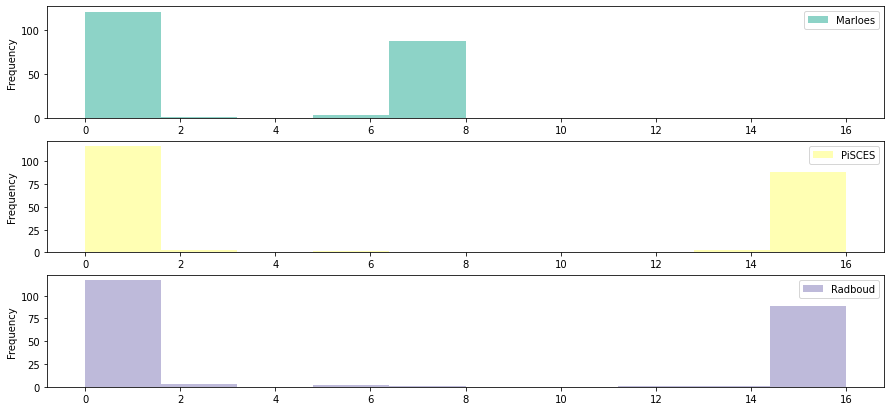

In [7]:
df_metadata[["Marloes", "PiSCES", "Radboud"]].plot(
    subplots=True,
    kind="hist",
    figsize=(15, 7),
    sharex=False,
    backend="matplotlib",
    color=sns.color_palette("Set3"),
)


In [8]:
df_metadata_relevant = (
    df_metadata[
        (df_metadata.Marloes >= 6)
        & (df_metadata.Radboud >= 13)
        & (df_metadata.PiSCES >= 13)
    ]
    .reset_index(drop=True)
    .copy()
)

df_metadata_relevant[
    ["age", "sex", "device", "Marloes", "PiSCES", "Radboud"]
].describe()


,age,Marloes,PiSCES,Radboud
count,90.000000,90.000000,90.000,90.000000
mean,28.211111,6.977778,15.000,14.988889
std,9.320142,0.148231,0.212,0.105409
min,19.000000,6.000000,14.000,14.000000
25%,23.000000,7.000000,15.000,15.000000
50%,26.000000,7.000000,15.000,15.000000
75%,30.750000,7.000000,15.000,15.000000
max,90.000000,7.000000,16.000,15.000000


male      45
female    44
other      1
Name: sex, dtype: int64

----------------------------------------


pc-mic       38
headset      17
earphones    16
other         6
Name: device, dtype: int64

----------------------------------------


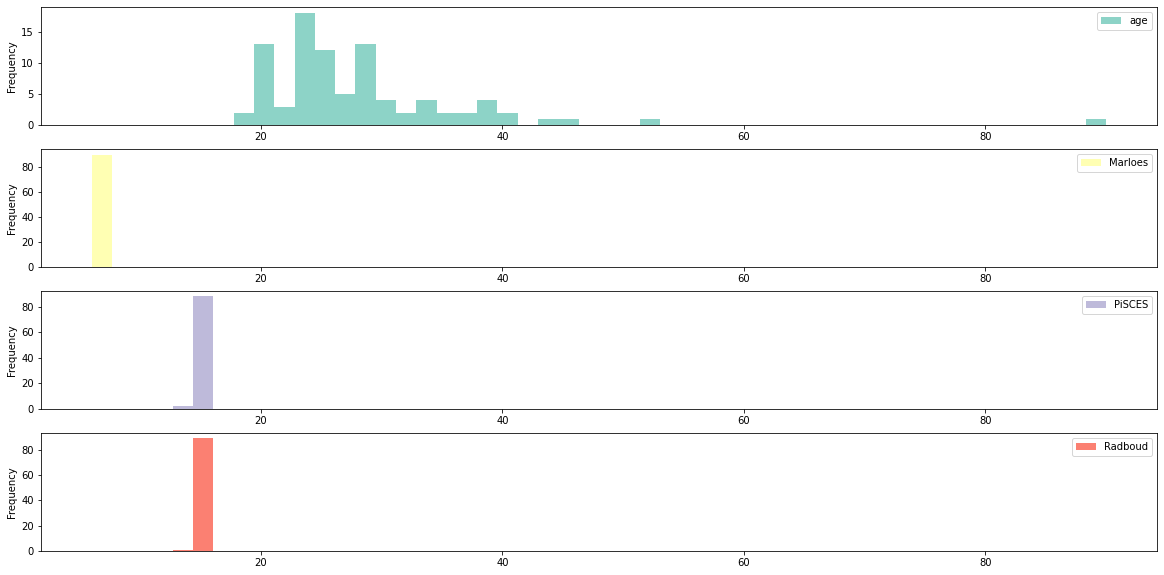

In [9]:
display(df_metadata_relevant.sex.value_counts())
print("-" * 40)
display(df_metadata_relevant.device.value_counts())
print("-" * 40)
df_metadata_relevant.education.value_counts()

# Also plot the distributions
df_metadata_relevant[["age", "device", "Marloes", "PiSCES", "Radboud"]].plot(
    kind="hist",
    subplots=True,
    sharex=False,
    figsize=(20, 10),
    backend="matplotlib",
    color=sns.color_palette("Set3"),
    bins=50,
);


In [10]:
df_metadata_relevant.to_parquet(loc_data_dir.joinpath("metadata_rel_ids.parquet"))


## Distilling sessions from the relevant metadata

In [11]:
session_dict_list = []

# creating alldata.csv
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue

    def parse_pic_name_ts(db_folder, pic_name, time_str, sep="__") -> dict:
        # what can we save from the wave file?
        # duration - size
        json_f = sep.join([pic_name, time_str]) + ".json"
        json_f = db_folder.joinpath(json_f)
        if not json_f.is_file():
            # print('json_f does not exist')
            return {}

        with open(json_f, "r") as f:
            return json.load(f)

    # TODO -> maybe we can also use the wav duration here as an extra assert.
    def get_wav_json_mapping(db_folder: Path) -> dict:
        # parse the wav files to construct a dataframe
        wav_list = list(db_folder.glob("*.wav"))
        df_db_wav = pd.Series(
            seq(wav_list).map(lambda x: x.name), name="wav_files", dtype="str"
        ).to_frame()
        df_db_wav["wav_time_str"] = df_db_wav["wav_files"].map(
            lambda x: x.split("__")[1].split(".")[0]
        )
        df_db_wav["wav_time_str"] = pd.to_datetime(
            "2022/01/01 " + df_db_wav["wav_time_str"], infer_datetime_format=True
        )
        df_db_wav = df_db_wav.sort_values(by="wav_time_str")

        # parse the json files to construct a datafraem
        json_list = list(db_folder.glob("*.json"))
        df_db_json = pd.Series(
            seq(json_list).map(lambda x: x.name), name="json_files", dtype="str"
        ).to_frame()
        df_db_json["json_time_str"] = df_db_json["json_files"].map(
            lambda x: x.split("__")[1].split(".")[0]
        )
        df_db_json["json_time_str"] = pd.to_datetime(
            "2022/01/01 " + df_db_json["json_time_str"], infer_datetime_format=True
        )
        df_db_json = df_db_json.sort_values(by="json_time_str")

        # TODO -> check if there is no overlapping data
        json_wav_mapping = pd.merge_asof(
            left=df_db_wav,
            right=df_db_json,
            left_on="wav_time_str",
            right_on="json_time_str",
            tolerance=pd.Timedelta(minutes=3),
            # A "forward" search selects the first row in the right DataFrame whose 'on' key
            # is greater than or equal to the left's key.
            direction="forward",
        )

        json_wav_mapping = json_wav_mapping.dropna(how="any", axis=0)
        json_wav_mapping = json_wav_mapping[
            ~(
                json_wav_mapping["wav_time_str"]
                < json_wav_mapping["json_time_str"].shift(1)
            )
        ].reset_index(drop=True)

        assert all(
            (
                json_wav_mapping["json_time_str"].shift(1)
                < json_wav_mapping["wav_time_str"]
            ).values[1:]
        )
        wav_json_mapping_dict = (
            json_wav_mapping[["json_files", "wav_files"]]
            .set_index("wav_files")
            .to_dict()["json_files"]
        )
        return wav_json_mapping_dict

    for db_folder in [folder.joinpath(x) for x in ["marloes", "Radboud", "PiSCES"]]:
        wav_json_mapping_dict = get_wav_json_mapping(db_folder)

        for wav_file in db_folder.glob("*.wav"):
            pic_name, time_str = wav_file.name.split("__")
            metadata_dict = parse_pic_name_ts(db_folder, pic_name, time_str)
            metadata_dict["pic_name"] = pic_name
            metadata_dict["time_str"] = time_str.split(".")[0]
            metadata_dict["wav_size"] = wav_file.stat().st_size
            data, sample_rate = librosa.load(path=wav_file, sr=None)
            metadata_dict["wav_sample_rate"] = sample_rate
            metadata_dict["wav_duration_s"] = round(data.shape[0] / sample_rate, 2)
            ts = pd.Timestamp(wav_file.stat().st_mtime, unit="s", tz="Europe/Brussels")
            metadata_dict["wav_timestamp"] = ts + ts.utcoffset()
            metadata_dict["ID"] = db_folder.parent.name.split("__")[-1]
            metadata_dict["DB"] = db_folder.name

            # also read the json file to fetch the arousal and valence values
            if wav_file.name in wav_json_mapping_dict:
                with open(
                    db_folder.joinpath(wav_json_mapping_dict[wav_file.name]), "r"
                ) as f:
                    json_dct = json.load(f)
                    metadata_dict["arousal"] = int(json_dct.get("arousal"))
                    metadata_dict["valence"] = int(json_dct.get("valence"))

            session_dict_list.append(metadata_dict)

df_session = pd.DataFrame(session_dict_list)

# Sanity check - to see whether the wav_time_obj corresponds with the time_str
# there must be < 10 minutes of difference between the two
assert all(
    (
        df_session.apply(
            lambda r: r.wav_timestamp.replace(
                **dict(
                    zip(
                        ["hour", "minute", "second"],
                        list(map(int, r.time_str.split(":"))),
                    )
                )
            ),
            axis=1,
        )
        - df_session.wav_timestamp
    ).abs()
    < pd.Timedelta(minutes=10)
)


del folder, db_folder, wav_file, ts, metadata_dict, session_dict_list, time_str, f
del parse_pic_name_ts, pic_name, wav_json_mapping_dict, json_dct, data, sample_rate

display(df_session.sample(3))

print("-" * 88)

df_session_tot = df_metadata_relevant.merge(
    df_session, how="left", left_on="ID", right_on="ID"
)
display(df_session_tot.sample(3))

del df_session


,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,ID,DB,arousal,valence
2298,Rafd090_24_Caucasian_male_neutral_frontal,15:04:03,5546028,48000,57.77,2022-06-29 15:04:04+02:00,0ce7b123-c80b-44f3-ad3e-f935d9072cef,Radboud,36.0,54.0
1378,marloes,14:14:37,3006508,48000,31.32,2022-06-23 14:14:38+02:00,ca947b80-e84b-45b6-90ae-9e8cbef7daa6,marloes,27.0,70.0
2272,Picture 59,14:52:13,6651948,48000,69.29,2022-06-29 14:52:12+02:00,42c842a5-7051-44c3-af42-cf824fded959,PiSCES,59.0,76.0


----------------------------------------------------------------------------------------


,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,prolific_token,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,DB,arousal,valence
2003,28,ho,female,2022-06-27 22:01:48.323990+02:00,0c28e160-d7bb-4b17-829c-c9ebc7ad0a1f,7,15,15,pc-mic,60fdb9bad55eb8c5b67f18f4,Rafd090_01_Caucasian_female_neutral_frontal,22:25:05,5947436,48000,61.95,2022-06-27 22:25:04+02:00,Radboud,4.0,58.0
835,37,unif,male,2020-12-04 21:44:43.508944+01:00,e0c00b33-2151-4bcf-98b8-82f7701fccea,7,16,15,headset,NaN,Picture 118,22:55:38,5685292,48000,59.22,2020-12-04 22:57:22+01:00,PiSCES,46.0,72.0
2741,25,ho,female,2022-07-17 13:09:11.536769+02:00,795f5119-2b11-49f9-80ea-e5a5ef61f4bf,7,15,15,headset,61115e026711eecf59e0e7ee,marloes,13:48:22,2277420,48000,23.72,2022-07-17 13:48:22+02:00,marloes,49.0,49.0


### Add the `DB_no` and `session_no` column

In [12]:
import numpy as np

# This is a simplified testcase to see whether the applied logic will work
test_arr = [1, 10, 3, 5, 2, 8, 100, 12, 200]
print(np.array(test_arr))
print(np.argsort(test_arr))
print(1 + np.argsort(np.argsort(test_arr)))


[  1  10   3   5   2   8 100  12 200]
[0 4 2 3 5 1 7 6 8]
[1 6 3 4 2 5 8 7 9]


In [13]:
df_session_tot["DB_no"] = df_session_tot.groupby(["ID", "DB"])["wav_timestamp"].apply(
    lambda s: 1 + s.argsort().argsort()
)
df_session_tot["session_no"] = df_session_tot.groupby(["ID"])["wav_timestamp"].apply(
    lambda s: 1 + s.argsort().argsort()
)

df_session_tot["pic_no"] = None
pic_mask = df_session_tot.DB != "marloes"
df_session_tot.loc[pic_mask, "pic_no"] = (
    df_session_tot[pic_mask]
    .groupby(["ID"])
    .wav_timestamp.apply(lambda s: 1 + s.argsort().argsort())
)


## Duration based visualizations

<AxesSubplot:ylabel='Frequency'>

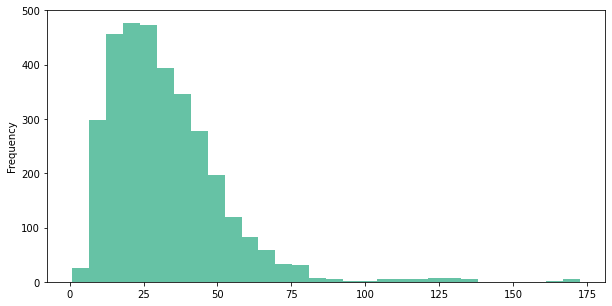

In [14]:
(
    (df_session_tot.wav_timestamp - df_session_tot.timestamp).dt.total_seconds() / 60
).plot.hist(backend='matplotlib', figsize=(10, 5), bins=30, color=sns.color_palette('Set2', 2))


<AxesSubplot:xlabel='wav_duration_s', ylabel='Count'>

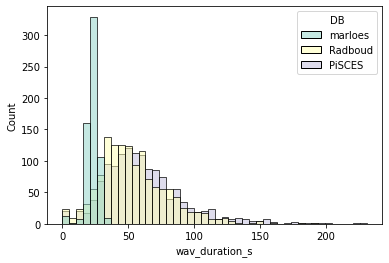

In [15]:
sns.histplot(
    data=df_session_tot,
    hue='DB',
    x='wav_duration_s',
    palette='Set3',
)

## Analyzing the sample rate

<AxesSubplot:>

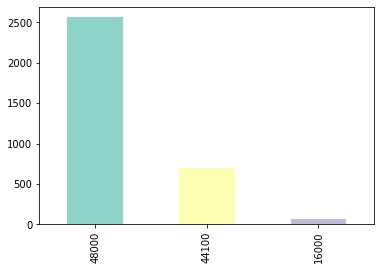

In [16]:
df_session_tot.wav_sample_rate.value_counts().plot.bar(
    backend="matplotlib", color=sns.color_palette("Set3")
)


### Investigating the file duration

In [17]:
df_session_tot[
    (df_session_tot.wav_size > 400)
    & (df_session_tot.wav_duration_s < 20)
    & (df_session_tot.DB != "marloes")
].groupby(["ID", "timestamp", "prolific_token", "DB"]).size().to_frame()


0
ID                                   timestamp                        prolific_token           DB         
87eafb16-0598-4340-9564-8e630acf85d6 2022-07-16 13:40:19.209381+02:00 5da367636f69c500149e6216 PiSCES   12
                                                                                               Radboud  13
9a725424-aafb-4d9b-8be7-acad80a46614 2022-07-27 14:55:01.266930+02:00 60fe5f65bf40c582873fefc2 Radboud   4
a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f 2022-06-27 22:18:01.896264+02:00 5f2be3f5d81eaf0009520f8b PiSCES   14
                                                                                               Radboud  15
c30db4c2-a62a-4d69-8f1b-893a1f4b8c9d 2022-07-16 21:49:33.730743+02:00 5e360d610d43625c7da0a09d Radboud   1
e61cd702-cd5f-4258-b4ef-57665e20803c 2022-06-29 14:23:23.366587+02:00 5b0c1fdebd9c3100015641ae PiSCES    1

### Filtering events

In [18]:
df_session_tot.sample(3)


,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,prolific_token,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,DB,arousal,valence,DB_no,session_no,pic_no
1473,23,unif,male,2022-06-23 11:42:14.555429+02:00,3021f503-6e98-4c4a-8102-08ed581fa208,7,15,15,earphones,61649545e0a3638d8488f414,Picture 87,12:14:10,1015852,16000,31.74,2022-06-23 12:14:10+02:00,PiSCES,75.0,75.0,12,28,23
804,39,unif,female,2020-12-04 21:09:06.904945+01:00,aef8bb4e-230d-42ae-a76a-dc5b37d97ff3,7,15,15,pc-mic,NaN,Picture 81,21:57:24,5390380,44100,61.11,2020-12-04 21:57:28+01:00,PiSCES,77.0,38.0,14,33,27
455,33,unif,male,2020-11-29 16:26:03.291969+01:00,5ef38e39-8146-4cf5-b365-43a08eac9905,7,15,15,NaN,NaN,Rafd090_32_Caucasian_female_neutral_frontal,16:47:06,1540140,44100,17.46,2020-11-29 16:47:06+01:00,Radboud,45.0,48.0,11,27,22


In [19]:
# We store the pic_count (number of times the user described the picutre) to use a a future filter
df_session_tot["pic_count"] = (
    df_session_tot[df_session_tot.DB != "marloes"]
    .groupby(["ID", "pic_name"])["pic_name"]
    .transform("count")
)

out = df_session_tot[df_session_tot.DB != "marloes"].groupby(["ID", "pic_name"]).size()
display(out[out > 1])
del out


ID                                    pic_name                                   
716dc108-5588-49ed-bf3c-04fb87212e2b  Picture 59                                     2
9223720f-1a2a-4811-84a1-a421646f63a0  Picture 59                                     2
e0c00b33-2151-4bcf-98b8-82f7701fccea  Picture 81                                     2
                                      Rafd090_32_Caucasian_female_neutral_frontal    2
dtype: int64

In [20]:
ids_to_skip = [
    "a97a84b6-7a66-461f-810e-b54bac686f64",  # Test run mitchel (a lot of short sessions)
    "a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f",  # Too much short sessions
    "87eafb16-0598-4340-9564-8e630acf85d6",  # This prolific users does not want to be included into the data analysis
    # TODO -> we do not need to throw thes all away; but for sake of simplicity we do now
    # "716dc108-5588-49ed-bf3c-04fb87212e2b",  # Got Picture 59 twice
    # "9223720f-1a2a-4811-84a1-a421646f63a0",  # Got Picture 59 twice
    # "e0c00b33-2151-4bcf-98b8-82f7701fccea",  # Got Picture 81 and Rafd090_32_Caucasian_female_neutral_frontal twice
]

df_session_tot_cleaned = df_session_tot[
    (~df_session_tot.ID.isin(ids_to_skip)) & (df_session_tot.wav_size > 400)
].copy()
df_session_tot_cleaned = df_session_tot_cleaned.sort_values(
    by=["ID", "wav_timestamp"], ignore_index=True
)
print(df_session_tot.shape)
display(df_session_tot_cleaned.shape)


(3327, 23)


(3194, 23)

In [21]:
# custom parsing
display(
    df_session_tot_cleaned[
        df_session_tot_cleaned.ID == "f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34"
    ]
    .sort_values(by="wav_timestamp")[["session_no", "wav_timestamp", "DB"]]
    .iloc[:10]
)
# this user starts with pisces and has a total of 6 marloes instead of 7
# for some reason, the first marloes was not stored -> adjust the session_no and DB_no
df_session_tot_cleaned.loc[
    df_session_tot_cleaned.ID == "f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34", "session_no"
] += 1
df_session_tot_cleaned.loc[
    (df_session_tot_cleaned.ID == ("f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34"))
    & (df_session_tot_cleaned.DB == "marloes"),
    "DB_no",
] += 1
display(
    df_session_tot_cleaned[
        df_session_tot_cleaned.ID == "f57eb3a1-bc73-4fb8-9c40-8a31a6b67e34"
    ]
    .sort_values(by="wav_timestamp")[["session_no", "wav_timestamp", "DB"]]
    .iloc[:10]
)


,session_no,wav_timestamp,DB
3084,1,2020-12-01 17:29:06+01:00,PiSCES
3085,2,2020-12-01 17:29:42+01:00,Radboud
3086,3,2020-12-01 17:30:44+01:00,PiSCES
3087,4,2020-12-01 17:31:22+01:00,Radboud
3088,5,2020-12-01 17:32:34+01:00,PiSCES
3089,6,2020-12-01 17:33:10+01:00,marloes
3090,7,2020-12-01 17:33:52+01:00,Radboud
3091,8,2020-12-01 17:34:44+01:00,PiSCES
3092,9,2020-12-01 17:36:02+01:00,Radboud
3093,10,2020-12-01 17:36:40+01:00,PiSCES


,session_no,wav_timestamp,DB
3084,2,2020-12-01 17:29:06+01:00,PiSCES
3085,3,2020-12-01 17:29:42+01:00,Radboud
3086,4,2020-12-01 17:30:44+01:00,PiSCES
3087,5,2020-12-01 17:31:22+01:00,Radboud
3088,6,2020-12-01 17:32:34+01:00,PiSCES
3089,7,2020-12-01 17:33:10+01:00,marloes
3090,8,2020-12-01 17:33:52+01:00,Radboud
3091,9,2020-12-01 17:34:44+01:00,PiSCES
3092,10,2020-12-01 17:36:02+01:00,Radboud
3093,11,2020-12-01 17:36:40+01:00,PiSCES


In [22]:
df_session_tot_cleaned[
    (df_session_tot_cleaned.wav_duration_s < 18)
    & (df_session_tot_cleaned.DB != "marloes")
].groupby(["ID", "timestamp", "DB"]).size().to_frame()


0
ID                                   timestamp                        DB        
0bae55f8-2aab-4c7b-917f-7f0c3e627e5f 2020-11-27 20:02:22.592132+01:00 Radboud  2
29fb88a7-d9de-428b-9905-88d1f05a6154 2020-12-09 15:55:02.026184+01:00 Radboud  7
3bdd33ef-9671-4a3e-b152-eff41ef674e8 2020-12-01 10:39:34.523391+01:00 Radboud  1
5ef38e39-8146-4cf5-b365-43a08eac9905 2020-11-29 16:26:03.291969+01:00 PiSCES   3
                                                                      Radboud  7
716dc108-5588-49ed-bf3c-04fb87212e2b 2020-11-27 12:06:42.365579+01:00 PiSCES   1
7e62dc42-e811-4674-ba8b-302850dd84e5 2020-11-30 13:47:57.876901+01:00 PiSCES   1
9a725424-aafb-4d9b-8be7-acad80a46614 2022-07-27 14:55:01.266930+02:00 Radboud  4
c30db4c2-a62a-4d69-8f1b-893a1f4b8c9d 2022-07-16 21:49:33.730743+02:00 Radboud  1

In [23]:
df_session_tot_cleaned.to_parquet(
    loc_data_dir.joinpath("df_session_tot_cleaned.parquet")
)

df_session_tot.to_parquet(loc_data_dir.joinpath("df_session_tot.parquet"))
